In [26]:
"""Librairies nécessaires"""

import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from tqdm import tqdm

In [27]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [28]:
"""Lecture du fichier des logements sociaux"""
emplacement_log_sociaux = '3.0) Enrichissement données/Données/Logements_sociaux_paris.geojson'
df_log_sociaux = gpd.read_file(emplacement_log_sociaux, low_memory=False, index_col=0)

In [29]:
"""On ne conserve que les logement sociaux de plus de 300 appartements"""
df_log_sociaux = df_log_sociaux.loc[df_log_sociaux['nb_logmt_total']>200]

In [30]:
"""Chargement des données administratives de Paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')

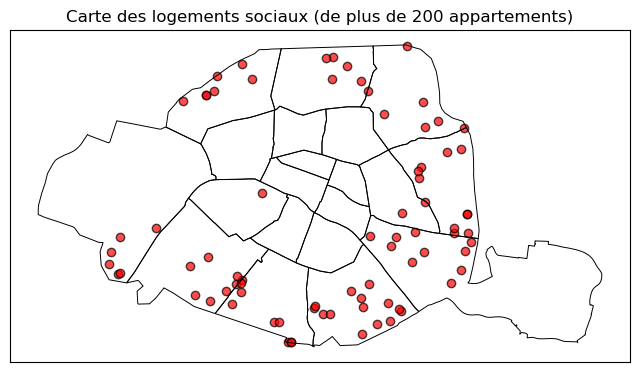

In [31]:
"""Visualisation des logements sociaux parisiens"""

fig, ax = plt.subplots(figsize=(8, 7))

paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge

df_log_sociaux.plot(ax=ax, color='red', alpha=0.7, edgecolor='black', linewidth=1) #on ajoute les lycées

#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

#titre
plt.title('Carte des logements sociaux (de plus de 200 appartements)')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_logements_sociaux_paris.png')
plt.show()

In [117]:
"""Fonction qui merge les data set en trouvant le logement social (point) le plus proche 
et enregistre la distance (en km)"""

def ajout_log_social(dvf, df_log_social):

    #sélection des variables
    var_log_social = ['geometry']
    df_log_social = df_log_social[var_log_social]
    df_log_social = df_log_social.drop_duplicates(['geometry'])
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_log_social = df_log_social.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_log_social, how="left", distance_col="dist_min_log_social")

    #dist en km
    merged_nearest['dist_min_log_social'] = merged_nearest['dist_min_log_social']/1000

    #repasser en système de projection wgs 84
    dvf_avec_log_social = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_log_social = dvf_avec_log_social.drop(['index_right'], axis=1)    

    #retirer les doublons
    dvf_avec_log_social = dvf_avec_log_social.drop_duplicates(['id_mutation', 'log_prix', 'geometry'])
    
    return dvf_avec_log_social

In [93]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)

In [118]:
"""Ajouter les logement sociaux"""

dvf_avec_log_social = ajout_log_social(dvf, df_log_sociaux)

In [116]:
"""Exportation"""

#chemin export
outer_path = '3.1) Données enrichies/'
outer_name = 'dvf_concat_2021_to_2023_avec_log_sociaux.geojson'

#exportation
dvf_avec_log_social.to_file(outer_path+outer_name, driver='GeoJSON')